In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import os
import re
import glob

from torchvision.transforms import Compose
from joblib import Parallel, delayed
from skimage.measure import block_reduce

from tqdm.notebook import tqdm

from copy import deepcopy
import gc

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Preliminaries and term library creation functions

In [2]:
'''
***************************************************

Extra Image Processing Functions

***************************************************
'''

class CellCrop(object):
    """
    min_factor is the minimum factor that the image dimensions should be. I.e. if 16, then each dimension must be a multiple of 16
    """
    def __init__(self, end_size, pad_type='zeros'):
        self.end_size = end_size
        self.pad_type = pad_type

    def __call__(self, sample):
        mask = sample['mask']
        t = np.max(np.nonzero(mask[0]), axis=1) # top right
        b = np.min(np.nonzero(mask[0]), axis=1) #bottom left

        cell_size = t-b
        if np.any(cell_size>=self.end_size): 
            cell_size=np.ones_like(cell_size)*self.end_size # 960 max im size
            noname=1	
        if np.any(cell_size == self.end_size):
            noname2=1
            cent = np.round(((t+b)/2)).astype(int)
            flexible_range = np.floor(((t-b)-self.end_size)/2)
            flexible_range = np.maximum(flexible_range, 0)
            pad_amt = self.end_size // 2
            cent += self.end_size // 2
            cent += [np.random.randint(-flexible_range[0], flexible_range[0]+1), np.random.randint(-flexible_range[1], flexible_range[1]+1)]

            pad = ((0,0), (pad_amt, pad_amt), (pad_amt,pad_amt))
            for key in sample:
                sample[key] = np.pad(sample[key], pad, mode='constant', constant_values=0) #pad first for boundary
                sample[key] = sample[key][:, cent[0]-pad_amt:cent[0]+pad_amt,cent[1]-pad_amt:cent[1]+pad_amt]
        else:
            for key in sample:
                sample[key] = sample[key][:, b[0]:t[0], b[1]:t[1]]

        pad = self.end_size - cell_size
        if np.any(pad<0): print(pad, cell_size)
        padL = np.floor(pad/2).astype(int)
        padR = np.ceil(pad/2).astype(int)

        pad = ((0,0),) + ((padL[0], padR[0]), (padL[1], padR[1]))

        if self.pad_type == 'zeros': kwargs={'mode': 'constant', 'constant_values': 0.}
        elif isinstance(self.pad_type, int):	kwargs = {'mode': 'constant', 'constant_values': self.pad_type}
        else:						 kwargs={'mode': 'reflect'}
        for key in sample:
            if key == 'mask': sample[key] = np.pad(sample[key], pad, mode=kwargs['mode'], constant_values=0)
            else: sample[key] = np.pad(sample[key], pad, **kwargs)

        try:
            assert(sample['mask'].shape[-2:]==(self.end_size, self.end_size))
        except:
            print(sample['mask'].shape)
            print(cell_size, t, b)
            print(np.unique(sample['mask']))
            print(noname, noname2)
            print(cent, pad_amt, pad)
        return sample

class Threshold(object):
    def __init__(self, key, threshold=0.3, rescale=1000):
        self.threshold = threshold
        self.rescale = rescale
        self.key = key

    def __call__(self, sample):
        sample[self.key] /= self.rescale
        thresh = np.linalg.norm(sample[self.key], axis=0) < self.threshold

        sample[self.key][:, thresh] = 0
        return sample

class ApplyMask(object):
    def __call__(self, sample):
        for key in sample:
            if key == 'mask': continue
            sample[key][..., sample['mask'][0] == 0] = 0
        return sample
    
class ToTensor(object):
    def __call__(self, sample):
        for key in sample.keys():
            sample[key] = torch.tensor(sample[key].copy(), 
                dtype=torch.bool if key == 'mask' else torch.float32)
        return sample
    
from skimage.measure import block_reduce
class Downsample(object):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, sample):
        for key in sample:
            sample[key] = block_reduce(sample[key], (1, self.factor, self.factor), np.mean)
        return sample

In [3]:
class CellPredictionsDataset(torch.utils.data.Dataset):
    def __init__(self,
                 mask_dir='/project/vitelli/cell_stress/TractionData_All_16kpa_new',
                 pred_dir='/project/vitelli/cell_stress/ForcePrediction_All_16kpa_new/AM_all_fixed_NormedF_dataset2/testsplit_0',
                 cell='11_cell_1',
                 transform=None):
        super(CellPredictionsDataset, self).__init__()
        self.transform = transform

        self.dataframe = pd.DataFrame(columns=['cell', 'idx', 'filename'])
        cells, idxs = [], np.zeros(0, dtype=int)
        subdir = os.path.join(mask_dir, cell)
        
        inputfiles = self.collect_folder(os.path.join(pred_dir, cell, 'inputs_*'))
        targetfiles = self.collect_folder(os.path.join(pred_dir, cell, 'outputs_*'))
        predfiles = self.collect_folder(os.path.join(pred_dir, cell, 'predictions_*'))
        
        self.dataframe = pd.DataFrame({'cell': [cell,] * len(inputfiles), 
                                       'zyxin': inputfiles,
                                       'Fexp': targetfiles,
                                       'Fml': predfiles})
        
        self.movies = np.concatenate(
            Parallel(n_jobs=8)(delayed(self.get_file_index)(i) for i in range(len(self.dataframe))))
        self.movies[:, 1:3] = np.stack([
            self.movies[:, 1] * np.cos(self.movies[:, 2]),
            self.movies[:, 1] * np.sin(self.movies[:, 2])], axis=1)
        gc.collect()

    def get_file_index(self, i):
        zyxin = np.load(self.dataframe.zyxin[i])
        Fml = np.load(self.dataframe.Fml[i])
        Fexp = np.load(self.dataframe.Fexp[i])
        return np.concatenate((zyxin, Fml, Fexp), axis=1)
        
    def collect_folder(self, dirpath):
        filenames = [f for f in glob.glob(os.path.join(dirpath, '*.npy'))]
        inds = [list(map(int, re.findall(r'\d+', f)))[-1] for f in filenames]
        return [f for _, f in sorted(zip(inds, filenames))]
    
    def __getitem__(self, idx):
        sample = {
            'zyxin': self.movies[idx, 0, None],
            'mask': self.movies[idx, 0, None] != 0,
            'Fml': self.movies[idx, 1:3],
            'Fexp': self.movies[idx, 3:]
        }
        
        sample = self.transform(sample)
        return sample

    def __len__(self):
        return len(self.dataframe)
    
    def collect_batch(self, indices):
        batch = Parallel(n_jobs=1)(delayed(self.__getitem__)(i) for i in indices)
        sample = {}
        for key in batch[0]:
            sample[key] = np.stack([b[key] for b in batch])
        return sample

In [4]:
mtwopii = -2.0j * np.pi        

class GetScalarTerms(object):
    scalar_names = [
        r'\zeta',
        r'\left( \nabla \zeta \right)^2',
        r'\nabla^2 \zeta',
        r'\zeta^2',
        r'\zeta \left( \nabla \zeta \right)^2',
        r'\zeta \nabla^2 \zeta',
    ]
    def __init__(self, cutoff=60):
        self.cutoff = cutoff
        
    def __call__(self, sample):
        with torch.no_grad():
            x = sample['zyxin'][0]
            xq = torch.fft.fft2(x, dim=(-2, -1))
            L = x.shape[-1]
            r = torch.arange(L, dtype=torch.float) - L // 2
            r = torch.fft.ifftshift(r)
            r = torch.linalg.norm(torch.stack(torch.meshgrid(r, r, indexing='ij')), dim=0)

            q = torch.fft.fftfreq(L)
            q = torch.stack(torch.meshgrid(q, q, indexing='xy'), dim=0)
            
            nmag = torch.linalg.norm(q * L, dim=-3)
            xq[..., nmag > self.cutoff] = 0.
            
            gradx = torch.fft.ifft2(mtwopii * q * xq[None, :, :], dim=(-2, -1)).real
            dx2x = torch.fft.ifft2(mtwopii**2 * q[0]**2 * xq, dim=(-2, -1)).real
            dy2x = torch.fft.ifft2(mtwopii**2 * q[1]**2 * xq, dim=(-2, -1)).real

            base_mags = [
                x,
                gradx.pow(2).sum(dim=-3),
                dx2x + dy2x
            ]

            charges = torch.stack([
                base_mags[0],
                base_mags[1],
                base_mags[2],
                base_mags[0]**2,
                base_mags[0] * base_mags[1],
                base_mags[0] * base_mags[2],
            ])

        return {
            'zyxin': sample['zyxin'],
            'charges': charges,
            'Fml': sample['Fml'],
            'Fexp': sample['Fexp'],
            'mask': sample['mask'],
        }

a = 0.1
sqrtpi = np.sqrt(np.pi)
def dirac_delta(r, a=a):
    return np.exp(-np.power(r / a, 2)) / (a * sqrtpi)

log10 = np.log(10.)
def exp_decay(r, l=10):
    return np.exp(- r / l * log10)

class GetClebschTerms(object):
    dir_funcs = [
        lambda r: 1. / (r + 0.1j),
        lambda r: r,
        #lambda r: dirac_delta(r),
        lambda r: torch.log(r + 0.1j),
        #lambda r: torch.sqrt(r),
        lambda r: exp_decay(r, 20),
        lambda r: exp_decay(r, 60),
    ]
    dir_names=[
        'r^{-1}',
        'r',
        #'\delta(x-r)',
        '\\log|r|',
        #'\sqrt{|x-r|}',
        'e^{-r / \\ell_1}',
        'e^{-r / \\ell_2}',
     ]
    
    @staticmethod
    def get_term_names(scalar_names):
        potential_names = []
        for i in range(len(scalar_names)):
            for j in range(len(GetClebschTerms.dir_names)):
                potential_names.append('\\big( %s \\star %s \\big)' % \
                                      (scalar_names[i], GetClebschTerms.dir_names[j]))
        
        phi_names = ['\\nabla %s' % pn for pn in potential_names]
        xichi_names = []
        for i in range(len(potential_names)):
            for j in range(len(potential_names)):
                xichi_names.append('%s \\nabla %s' % (potential_names[i], potential_names[j]))
        
        return xichi_names + phi_names
    
    def __call__(self, sample):
        with torch.no_grad():
            charges = sample['charges']
            L = charges.shape[-1]
            r = torch.arange(L, dtype=torch.float) - L // 2
            r = torch.fft.ifftshift(r)
            r = torch.linalg.norm(torch.stack(torch.meshgrid(r, r, indexing='ij')), dim=0)

            q = torch.fft.fftfreq(L)
            q = torch.stack(torch.meshgrid(q, q, indexing='xy'), dim=0)

            gr = torch.stack([df(r) for df in self.dir_funcs])
            cq = torch.fft.fft2(charges, dim=(-2, -1))
            gq = torch.fft.fft2(gr, dim=(-2, -1))

            terms = []
            #Generate terms which could appear in Clebsch potentials
            potentials_q = torch.einsum('iyx,jyx->ijyx', cq, gq)
            potentials_q = potentials_q.reshape([-1, *potentials_q.shape[-2:]])
                        
            #Generate vectorial_terms from Clebsch potentials
            potentials = torch.fft.ifft2(potentials_q, dim=(-2, -1)).real
            grad_potentials = torch.fft.ifft2(mtwopii * q * potentials_q[:, None], dim=(-2, -1)).real
                        
            nl_terms = torch.einsum('ayx,biyx->abiyx', potentials, grad_potentials)
            nl_terms = nl_terms.reshape([-1, 2, *potentials.shape[-2:]])
            terms = torch.cat([nl_terms, grad_potentials], dim=0)
 
        return {
            'zyxin': sample['zyxin'],
            'terms': terms,
            'Fml': sample['Fml'],
            'Fexp': sample['Fexp'],
            'mask': sample['mask'],
        }

In [5]:
from torchvision.transforms import Compose
transform = Compose([
    CellCrop(800, pad_type=0),
    Threshold('Fexp', threshold=0.5, rescale=1),
    Threshold('Fml', threshold=0.5, rescale=1),
    Downsample(2),
    ToTensor(),
    GetScalarTerms(cutoff=50),
    GetClebschTerms(),
])

In [6]:
dataset = CellPredictionsDataset(cell='11_cell_1', transform=transform)
train_batch = dataset.collect_batch(np.arange(16))

In [7]:
test_batch = dataset.collect_batch(np.arange(36, 44))
X_test = test_batch['terms'].transpose(1, 0, 2, 3, 4)
X_test = X_test.reshape([-1, *X_test.shape[-4:]])
X_test = X_test[:, test_batch['mask'].repeat(X_test.shape[-3], axis=-3)].T
y0_test = test_batch['Fml']
y0_test = y0_test[test_batch['mask'].repeat(y0_test.shape[-3], axis=-3)][:, None]

# Fitting on neural network outputs

In [12]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
import pysindy as ps

X_scaler = MaxAbsScaler()
X_scaler = StandardScaler()
y0_scaler = StandardScaler()
train_points = 50000

# ##### Two Standard Scalers, ElasticNet Optimization, Downsample 2, FC 50
alpha = 5e-1 #16 terms
alpha = 8e-1 #9 terms
alpha = .75 #10 terms

X_train = train_batch['terms'].transpose(1, 0, 2, 3, 4)
X_train = X_train.reshape([-1, *X_train.shape[-4:]])
X_train = X_train[:, train_batch['mask'].repeat(X_train.shape[-3], axis=-3)].T
y0_train = train_batch['Fml']
y0_train = y0_train[train_batch['mask'].repeat(y0_train.shape[-3], axis=-3)][:, None]

input_mask = np.zeros(len(y0_train), dtype=bool)
input_mask[np.random.randint(len(input_mask), size=train_points)] = True

X_scaler.fit(X_train[input_mask])
X_train = X_scaler.transform(X_train)
y0_scaler.fit(y0_train[input_mask])
y0_train = y0_scaler.transform(y0_train)

model = ps.SINDy(optimizer=ElasticNet(alpha=alpha),
                 feature_library=ps.IdentityLibrary(),
                 feature_names=GetClebschTerms.get_term_names(GetScalarTerms.scalar_names))
model.fit(X_train[input_mask], x_dot=y0_train[input_mask]);
print('R2 (higher is better): %.3g' % model.score(X_train[input_mask], x_dot=y0_train[input_mask]))
print('MSE (lower is better): %.3g' % model.score(X_train[input_mask], x_dot=y0_train[input_mask], 
                                                  metric=mean_squared_error))
print('Number of terms: %d' % np.sum(model.coefficients() != 0))

eqn = model.equations(precision=1)
from IPython.display import display, Markdown
display(Markdown(r'$\mathbf{F} = %s$' % eqn[0]))

R2 (higher is better): 0.562
MSE (lower is better): 0.438
Number of terms: 10


$\mathbf{F} = -0.2 \big( \nabla^2 \zeta \star \log|r| \big) \nabla \big( \zeta \star \log|r| \big) + -0.3 \big( \nabla^2 \zeta \star e^{-r / \ell_1} \big) \nabla \big( \zeta \star \log|r| \big) + 0.3 \big( \nabla^2 \zeta \star e^{-r / \ell_1} \big) \nabla \big( \zeta \star e^{-r / \ell_2} \big) + 0.6 \big( \nabla^2 \zeta \star e^{-r / \ell_2} \big) \nabla \big( \zeta \star \log|r| \big) + 0.3 \big( \nabla^2 \zeta \star e^{-r / \ell_2} \big) \nabla \big( \zeta \star e^{-r / \ell_2} \big) + -0.2 \big( \nabla^2 \zeta \star e^{-r / \ell_2} \big) \nabla \big( \zeta^2 \star r \big) + 0.1 \big( \zeta^2 \star e^{-r / \ell_1} \big) \nabla \big( \zeta \star \log|r| \big) + -0.4 \big( \zeta^2 \star e^{-r / \ell_1} \big) \nabla \big( \zeta \star e^{-r / \ell_2} \big) + 0.2 \big( \zeta^2 \star e^{-r / \ell_1} \big) \nabla \big( \zeta^2 \star r \big)$

8.460028538024051 -8.007928863524777 0.33877642056943336


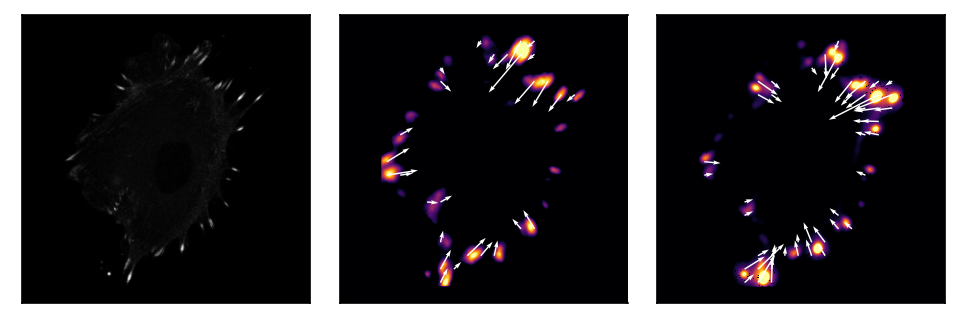

In [17]:
def make_vector_field(v, downsample=14, threshold=0.4):
    Y, X = np.mgrid[:v.shape[-2], :v.shape[-1]]
    X = block_reduce(X, (downsample, downsample), np.mean)
    Y = block_reduce(Y, (downsample, downsample), np.mean)
    vx = block_reduce(v[0], (downsample, downsample), np.mean)
    vy = block_reduce(v[1], (downsample, downsample), np.mean)
    mask = vx**2 + vy**2 > threshold**2
    return X[mask], Y[mask], vx[mask], vy[mask]

def revert_shape(v, mask):
    vr = np.zeros([mask.shape[0], 2, *mask.shape[-2:]])
    vr[mask.repeat(2, axis=-3)] = v[:, 0]
    return vr

crop = 50
idx = 4
#y = model.predict(X_scaler.transform(X_test))
mask = test_batch['mask']
y0_show = test_batch['Fml'][idx]
y_show = revert_shape(y0_scaler.inverse_transform(y), mask)[idx]
print(np.max(y_show), np.min(y_show), np.std(y_show))
fig, ax = plt.subplots(1, 3, dpi=150, figsize=(6.5, 3))
ax = ax.flatten()
for a in ax: a.set(xticks=[], yticks=[])
ax[0].imshow(test_batch['zyxin'][idx, 0, crop:-crop, crop:-crop], origin='lower', cmap='Greys_r', vmin=0)
kwargs = {'origin': 'lower', 'cmap': 'inferno', 'vmin': 0.5, 'vmax': 4}
ax[1].imshow(np.linalg.norm(y0_show, axis=0)[crop:-crop, crop:-crop], **kwargs)
ax[2].imshow(np.linalg.norm(y_show, axis=0)[crop:-crop, crop:-crop], **kwargs)
qwargs = {'color': 'w', 'width': 0.005, 'scale': 22}
threshold=0.6
ax[1].quiver(*make_vector_field(y0_show[:, crop:-crop, crop:-crop], threshold=threshold), **qwargs)
ax[2].quiver(*make_vector_field(y_show[:, crop:-crop, crop:-crop], threshold=threshold), **qwargs)

plt.tight_layout()

In [18]:
def revert_shape(v, mask):
    vr = np.zeros([2, *mask.shape[-2:]])
    vr[mask.repeat(2, axis=-3)] = v[:, 0]
    return vr

def predict_frame(model, dataset, X_scaler, y0_scaler, index):
    batch = dataset[index]
    X, mask = batch['terms'], batch['mask'].bool().numpy()
    mout = mask.repeat(2, axis=-3)
    mse_ml_exp = np.mean(np.power(batch['Fml'] - batch['Fexp'], 2).numpy()[mout])
    X = X[:, mask.repeat(X.shape[-3], axis=-3)].T
    X = X_scaler.transform(X)
    mse_mo_exp = []
    num_terms = []
    complexity = np.sum(model.coefficients() != 0)
    num_terms.append(complexity)
    y = model.predict(X)
    y = revert_shape(y0_scaler.inverse_transform(y), mask)
    mse_mo_exp.append(np.mean(np.power(y - batch['Fexp'].numpy(), 2)[mout]))
    
    exp_sum = np.linalg.norm(batch['Fexp'], axis=-3).sum()
    ml_sum = np.linalg.norm(batch['Fml'], axis=-3).sum()
    mo_sum = np.linalg.norm(y, axis=-3).sum()
    
    out = pd.DataFrame({
        'num_terms': num_terms, 
        'mse_mo': mse_mo_exp,
        'mse_ML': mse_ml_exp,
        'Fexp': exp_sum,
        'Fml': ml_sum,
        'Fmo': mo_sum,
        'frame': index,
    })
    return out

test_results = pd.concat(
    Parallel(n_jobs=8)(delayed(predict_frame)(model, dataset, X_scaler, y0_scaler, i) for i in range(len(dataset))),
    ignore_index=True)
test_results.head()

,num_terms,mse_mo,mse_ML,Fexp,Fml,Fmo,frame
0,10,0.177170,0.169418,15167.315430,10981.501953,12334.156805,0
1,10,0.166095,0.161611,15626.291992,11205.685547,11355.671692,1
2,10,0.177181,0.154967,16397.691406,12773.638672,11096.668956,2
3,10,0.187561,0.193257,17418.787109,12797.876953,11350.820310,3
4,10,0.174001,0.172534,16876.201172,13997.667969,11575.242859,4


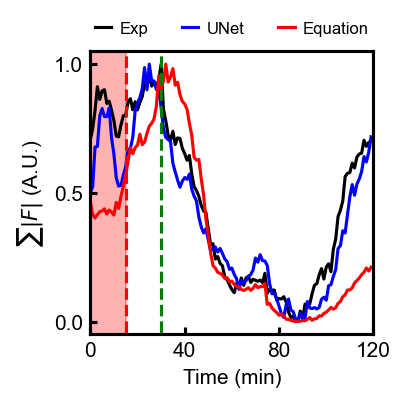

In [20]:
from sklearn.preprocessing import MinMaxScaler
def smooth(x, window=5): 
    x = np.pad(x, (window//2, window//2), mode='edge')
    return np.convolve(x, np.ones(window) / window, mode='valid')

def scale_equiv_plot(df):
    scaler = MinMaxScaler()

    fig = plt.figure(figsize=(2.5, 2.5), dpi=150)
    ax = fig.gca()
    window = 1
    df['smooth_F_Exp'] = smooth(df.Fexp, window=window)
    df['smooth_F_ML'] = smooth(df.Fml, window=window)
    df['smooth_F'] = smooth(df.Fmo, window=window)
    df[df.columns] = scaler.fit_transform(df[df.columns])
    t = smooth(df.index, window=window)
    ax.plot(t, df.smooth_F_Exp, color='black', label='Exp')
    ax.plot(t, df.smooth_F_ML, color='blue', label='UNet')
    ax.plot(t, df.smooth_F, color='red', label='Equation')
    ax.axvline(x=15, ymin=-0.05, ymax=1.05, color='red', linestyle='--')
    ax.axvline(x=30, ymin=-0.05, ymax=1.05, color='green', linestyle='--')
    ax.fill_betweenx(y=ax.get_ylim(), x1=0, x2=15, color='red', alpha=0.3)
    #ax.text(32, -0.02, 'Y-Compound\nwash-in', va='bottom', ha='left', color='green')
    #ax.text(18, 0.2, 'Fitting\nwindow', va='bottom', ha='left', color='red', backgroundcolor='white')

    ax.set(xlim=[0, 120], xticks=[0, 40, 80, 120], xlabel='Time (min)')
    ax.set(ylim=[-0.05, 1.05], yticks=[0, 0.5, 1], ylabel='$\\sum|F|$ (A.U.)')
    ax.legend(ncol=3, bbox_to_anchor=[0.5, 1], loc='lower center')

    ax.set_aspect(120 / 1.1)

import matplotlib.font_manager
lw = 1.5
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['font.size'] = 10
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.fontsize'] = plt.rcParams['font.size'] - 2
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.handlelength'] = 1.
    
scale_equiv_plot(test_results.copy())

# Build the entire plot row

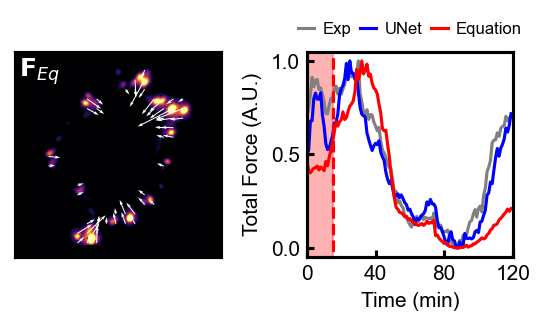

In [62]:
def make_vector_field(v, downsample=14, threshold=0.4):
    Y, X = np.mgrid[:v.shape[-2], :v.shape[-1]]
    X = block_reduce(X, (downsample, downsample), np.mean)
    Y = block_reduce(Y, (downsample, downsample), np.mean)
    vx = block_reduce(v[0], (downsample, downsample), np.mean)
    vy = block_reduce(v[1], (downsample, downsample), np.mean)
    mask = vx**2 + vy**2 > threshold**2
    return X[mask], Y[mask], vx[mask], vy[mask]

from sklearn.preprocessing import MinMaxScaler
def smooth(x, window=5): 
    x = np.pad(x, (window//2, window//2), mode='edge')
    return np.convolve(x, np.ones(window) / window, mode='valid')

def scale_equiv_plot(ax, df):
    scaler = MinMaxScaler()

    window = 1
    df['smooth_F_Exp'] = smooth(df.Fexp, window=window)
    df['smooth_F_ML'] = smooth(df.Fml, window=window)
    df['smooth_F'] = smooth(df.Fmo, window=window)
    df[df.columns] = scaler.fit_transform(df[df.columns])
    t = smooth(df.index, window=window)
    ax.plot(t, df.smooth_F_Exp, color='grey', label='Exp')
    ax.plot(t, df.smooth_F_ML, color='blue', label='UNet')
    ax.plot(t, df.smooth_F, color='red', label='Equation')
    ax.axvline(x=15, ymin=-0.05, ymax=1.05, color='red', linestyle='--')
    #ax.axvline(x=30, ymin=-0.05, ymax=1.05, color='green', linestyle='--')
    ax.fill_betweenx(y=ax.get_ylim(), x1=0, x2=15, color='red', alpha=0.3)
    #ax.text(32, -0.02, 'Y-Compound\nwash-in', va='bottom', ha='left', color='green')
    #ax.text(18, 0.2, 'Fitting\nwindow', va='bottom', ha='left', color='red', backgroundcolor='white')

    ax.set(xlim=[0, 120], xticks=[0, 40, 80, 120], xlabel='Time (min)')
    ax.set(ylim=[-0.05, 1.05], yticks=[0, 0.5, 1], ylabel='Total Force (A.U.)')
    ax.legend(ncol=3, bbox_to_anchor=[0.5, 1], loc='lower center')

    ax.set_aspect(120 / 1.1)

lw = 1.5
import matplotlib.font_manager
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['font.size'] = 10
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.fontsize'] = plt.rcParams['font.size'] - 2
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.columnspacing'] = .5
plt.rcParams['text.usetex'] = False
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(1, 2, dpi=150, figsize=(3.75, 3), constrained_layout=True)


kwargs = {'origin': 'lower', 'cmap': 'inferno', 'vmin': 0.5, 'vmax': 4}
qwargs = {'color': 'w', 'width': 0.005, 'scale': 22}
threshold=0.6
ax[0].imshow(np.linalg.norm(y_show, axis=0)[crop:-crop, crop:-crop], **kwargs)
ax[0].quiver(*make_vector_field(y_show[:, crop:-crop, crop:-crop], threshold=threshold), **qwargs)
ax[0].set(xticks=[], yticks=[])


scale_equiv_plot(ax[1], test_results.copy())

plt.tight_layout()

x0, y0 = 0.02, 0.98
kwargs = dict(va='top',ha='left', color='white', fontsize=plt.rcParams['font.size'] + 2)
fig.text(x0, y0, '$\\mathbf{F}_{Eq}$', transform=ax[0].transAxes, **kwargs)

plt.savefig('sindy_11cell1_halfrow.svg')

In [78]:
'''
Smaller version
'''

lw = .75
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['lines.linewidth'] = lw
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['font.size'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2

plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.fontsize'] = plt.rcParams['font.size'] - 2
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.handlelength'] = .5
plt.rcParams['legend.columnspacing'] = .5
plt.rcParams['legend.borderpad'] = 0.


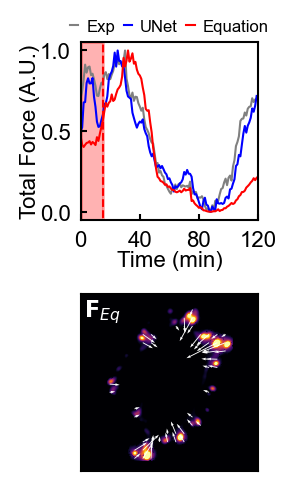

In [94]:
def make_vector_field(v, downsample=14, threshold=0.4):
    Y, X = np.mgrid[:v.shape[-2], :v.shape[-1]]
    X = block_reduce(X, (downsample, downsample), np.mean)
    Y = block_reduce(Y, (downsample, downsample), np.mean)
    vx = block_reduce(v[0], (downsample, downsample), np.mean)
    vy = block_reduce(v[1], (downsample, downsample), np.mean)
    mask = vx**2 + vy**2 > threshold**2
    return X[mask], Y[mask], vx[mask], vy[mask]

from sklearn.preprocessing import MinMaxScaler
def smooth(x, window=5): 
    x = np.pad(x, (window//2, window//2), mode='edge')
    return np.convolve(x, np.ones(window) / window, mode='valid')

def scale_equiv_plot(ax, df):
    scaler = MinMaxScaler()

    window = 1
    df['smooth_F_Exp'] = smooth(df.Fexp, window=window)
    df['smooth_F_ML'] = smooth(df.Fml, window=window)
    df['smooth_F'] = smooth(df.Fmo, window=window)
    df[df.columns] = scaler.fit_transform(df[df.columns])
    t = smooth(df.index, window=window)
    ax.plot(t, df.smooth_F_Exp, color='grey', label='Exp')
    ax.plot(t, df.smooth_F_ML, color='blue', label='UNet')
    ax.plot(t, df.smooth_F, color='red', label='Equation')
    ax.axvline(x=15, ymin=-0.05, ymax=1.05, color='red', linestyle='--')
    #ax.axvline(x=30, ymin=-0.05, ymax=1.05, color='green', linestyle='--')
    ax.fill_betweenx(y=ax.get_ylim(), x1=0, x2=15, color='red', alpha=0.3)
    #ax.text(32, -0.02, 'Y-Compound\nwash-in', va='bottom', ha='left', color='green')
    #ax.text(18, 0.2, 'Fitting\nwindow', va='bottom', ha='left', color='red', backgroundcolor='white')

    ax.set(xlim=[0, 120], xticks=[0, 40, 80, 120], xlabel='Time (min)')
    ax.set(ylim=[-0.05, 1.05], yticks=[0, 0.5, 1], ylabel='Total Force (A.U.)')
    ax.legend(ncol=3, bbox_to_anchor=[0.5, 1], loc='lower center')

    ax.set_aspect(120 / 1.1)

fig, ax = plt.subplots(2, 1, dpi=200, 
                       figsize=(1.75, 2.5), constrained_layout=True)


kwargs = {'origin': 'lower', 'cmap': 'inferno', 'vmin': 0.5, 'vmax': 4}
qwargs = {'color': 'w', 'width': 0.005, 'scale': 22}
threshold=0.6
ax[1].imshow(np.linalg.norm(y_show, axis=0)[crop:-crop, crop:-crop], **kwargs)
ax[1].quiver(*make_vector_field(y_show[:, crop:-crop, crop:-crop], threshold=threshold), **qwargs)
ax[1].set(xticks=[], yticks=[])


scale_equiv_plot(ax[0], test_results.copy())

plt.tight_layout()

x0, y0 = 0.02, 0.98
kwargs = dict(va='top',ha='left', color='white', fontsize=plt.rcParams['font.size'])
fig.text(x0, y0, '$\\mathbf{F}_{Eq}$', transform=ax[1].transAxes, **kwargs)

plt.savefig('sindy_11cell1_halfrow_SMALL.svg', dpi=200)